In [115]:
import tensorflow as tf
import numpy as np
import scipy.io as io
from scipy.interpolate import interp1d
import scipy.signal as signal
from itertools import chain
from model.filter import filtfilt

from time import time
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 12, 8
matplotlib.rcParams.update({'font.size': 30})

def getconst(constant, **kwargs):
    #return tf.Variable(constant, trainable=False, dtype=tf.float32, **kwargs)
    return tf.constant(constant, dtype=tf.float32, **kwargs)

In [34]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, None], name='input')
A, B = np.random.randn(2, 30)
a = getconst(A)
b = getconst(B)

tf_filt = filtfilt(b, a, x)

In [51]:
def measure_tf(sample_list, A=A, B=B):
    res = []
    for i, sample in enumerate(sample_list):
        print('\r%d/%d'%(i, len(sample_list)), flush=True, end='')
        t = time()
        sess.run(tf_filt, {x:sample, a:A, b:B})
        res.append(time()-t)
    return res

In [63]:
def measure_scipy(sample_list, A=A, B=B, batch=False):
    
    res = []
    if batch:
        for i, batch in enumerate(sample_list):
            print('\r%d/%d'%(i, len(sample_list)), flush=True, end='')
            t = time()
            for sample in batch:
                signal.filtfilt(B, A, sample.squeeze())
            res.append(time()-t)
        return res
    
    for i, sample in enumerate(sample_list):
        print('\r%d/%d'%(i, len(sample_list)), flush=True, end='')
        t = time()
        signal.filtfilt(B, A, sample.squeeze())
        res.append(time()-t)
    return res

# Single sample - Single filter run, with different sample lengths

In [53]:
#lengths = list(set(np.logspace(2, 4, 100, dtype=int)*2))
lengths = np.linspace(100, 20000, 50, dtype=int)
lengths.sort()

sample_list = [np.random.randn(1, l) for l in lengths]
scp_time = measure_scipy(sample_list)
tf_time = measure_tf(sample_list)



19/50

KeyboardInterrupt: 

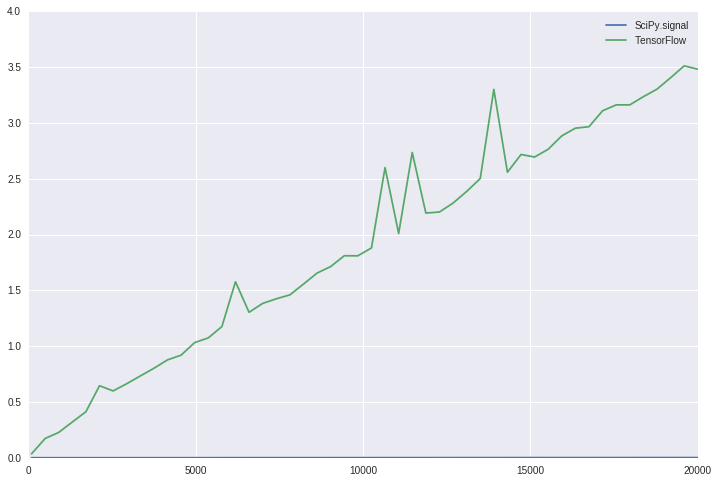

In [43]:
plt.plot(lengths, scp_time)
plt.plot(lengths, tf_time)
plt.legend(['SciPy.signal', 'TensorFlow'])

# Batch samples - Single filter run, with same length samples

199/200

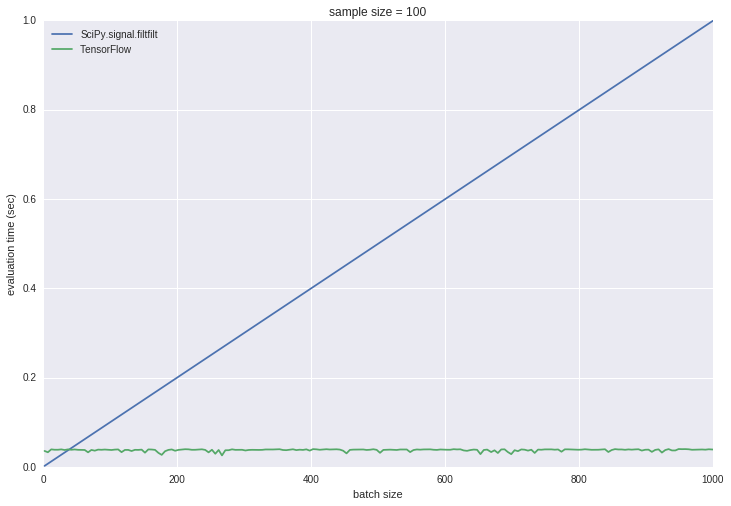

In [116]:
#lengths = list(set(np.logspace(2, 4, 100, dtype=int)*2))
batch_size = np.linspace(2, 1000, 200, dtype=int)
lengths.sort()

sample_list = [np.random.randn(b, 100) for b in batch_size]
scp_batch_time = scp_time[0] * batch_size
#print('\n')
tf_batch_time_100 = measure_tf(sample_list)

plt.plot(batch_size, scp_batch_time, label='SciPy.signal.filtfilt')
plt.plot(batch_size, tf_batch_time_100, label='TensorFlow')
plt.title('sample size = 100')
plt.xlabel('batch size')
plt.ylabel('evaluation time (sec)')
_ = plt.legend(loc=2) 


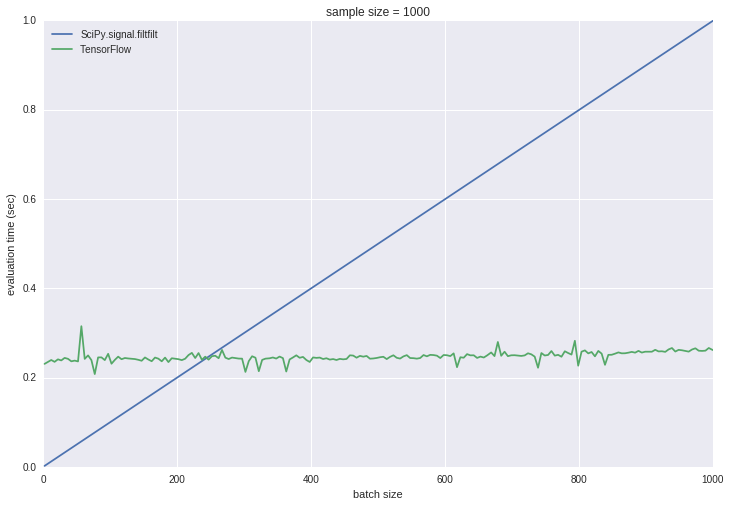

In [112]:
#lengths = list(set(np.logspace(2, 4, 100, dtype=int)*2))
batch_size = np.linspace(2, 1000, 200, dtype=int)
lengths.sort()

sample_list = [np.random.randn(b, 1000) for b in batch_size]
scp_batch_time = scp_time[0] * batch_size
#print('\n')
#tf_batch_time = measure_tf(sample_list)

plt.plot(batch_size, scp_batch_time, label='SciPy.signal.filtfilt')
plt.plot(batch_size, tf_batch_time, label='TensorFlow')
plt.title('sample size = 1000')
plt.xlabel('batch size')
plt.ylabel('evaluation time (sec)')
_ = plt.legend(loc=2) 


199/200

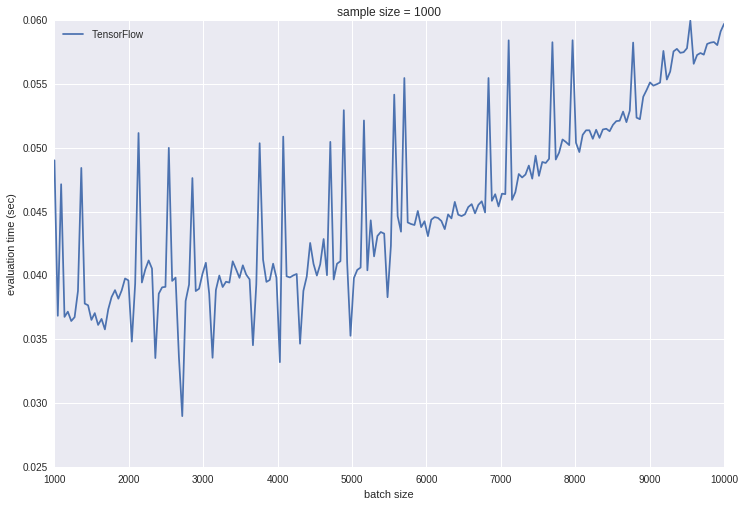

In [120]:
#lengths = list(set(np.logspace(2, 4, 100, dtype=int)*2))
batch_size = np.linspace(1000, 10000, 200, dtype=int)
lengths.sort()

sample_list = [np.random.randn(b, 100) for b in batch_size]
#scp_batch_time = scp_time[0] * batch_size
#print('\n')
tf_batch_time_LARGE = measure_tf(sample_list)

#plt.plot(batch_size, scp_batch_time, label='SciPy.signal.filtfilt')
plt.plot(batch_size, tf_batch_time_LARGE, label='TensorFlow')
plt.title('sample size = 1000')
plt.xlabel('batch size')
plt.ylabel('evaluation time (sec)')
_ = plt.legend(loc=2) 
